In [1]:
import gym
import matplotlib.pyplot as plt
import ray
from ray.rllib.agents.ppo import PPOTrainer
from navigation_gym.tasks.navigation_discrete_task import NavigationDiscreteTask
import numpy as np
import seaborn as sns
from pathlib import Path
import rosbag
from tf_bag import BagTfTransformer
import math
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


## Register Environment

In [2]:
env = gym.make('Navigation-v0')

print("Observation Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space))

/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-navigation/navigation_gym/src/navigation_gym/tasks/navigation_discrete_task.py:25: UserWarning: 'rl-navigation_39402_1615201701341' is not a legal ROS base name. This may cause problems with other ROS tools.
  rospy.init_node('rl-navigation', anonymous=True, log_level=rospy.INFO)
[ERROR] [1615201701.509686, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1615201701.515522, 0.000000]: Start Init ControllersConnection
[WARN] [1615201701.516872, 0.000000]: END Init ControllersConnection


Observation Space: Box(0.0, 1.0, (84, 84, 4), float32)
Action Space: Discrete(3)


## Check Environment State

In [3]:
obs = env.reset()

## Ray Configs

In [4]:
config = {
    "env": NavigationDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    "num_gpus": 1,
    "num_workers": 1,
    #"model": {"dim": 84,
    #          "conv_filters":
    #              [[16, [3, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [128, [11, 11], 1]]}
}

stop = {
    "episodes_total": 6000,
}

In [5]:
ray.init()

2021-03-08 12:08:24,949	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-03-08_12-08-24_332356_39402/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-08_12-08-24_332356_39402/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-08_12-08-24_332356_39402',
 'metrics_export_port': 57386,
 'node_id': 'fd622335bccddf5689bb7f580bfaa3b81c9fd2c5'}

## Train

In [6]:
def test_traj(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    positions = []
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        positions.append(info['position'])
        episode_reward += reward

    return episode_reward, positions

def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent

## Test Run

In [ ]:
# Video recording
import time
checkpoints = [1, 40, 80, 120, 164]
for checkpoint in checkpoints:
    time_now = time.time()
    print(checkpoint)
    checkpoint_nr = checkpoint
    checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                  'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
    agent = load(checkpoint_path=checkpoint_path, config=config)
    env.img_prefix = 'check_{}'.format(checkpoint)
    while True:
        episode_reward = test_traj(agent=agent, env=env)
        if time.time() - time_now > 150:
            break
    time.sleep(10)

# Trajectories

Functions

In [ ]:
AGENT_DIR = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                      'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03'

def run_trajectories_tests(runs, checkpoints):
    data = {}
    data['trajectories'] = {}
    data['success_rate'] = {}
    for checkpoint in checkpoints:
        checkpoint_nr = checkpoint
        checkpoint_path = '{}/' \
                      'checkpoint_{}/checkpoint-{}'.format(AGENT_DIR, checkpoint_nr, checkpoint_nr)
        agent = load(checkpoint_path=checkpoint_path, config=config)
        data['trajectories']['checkpoint_traj_{}'.format(checkpoint)] = {}
        data['success_rate']['checkpoint_success_{}'.format(checkpoint)] = {}
        for i in range(runs):
            env.img_prefix = 'checkpoint{}_run{}'.format(checkpoint, i+1)
            episode_reward, positions = test_traj(agent=agent, env=env)
            data['trajectories']['checkpoint_traj_{}'.format(checkpoint)]['run{}'.format(i)] = positions
            if episode_reward > 0:
               data['success_rate']['checkpoint_success_{}'.format(checkpoint)]['run{}'.format(i+1)] = True
            else:
               data['success_rate']['checkpoint_success_{}'.format(checkpoint)]['run{}'.format(i+1)] = False

    return data

def visualize_trajectories(ax, data, output_path, typ='traj'):
    ax.set_xlabel('X- Coordinates (m)', fontsize=16)
    ax.set_ylabel('Y- Coordinates (m)', fontsize=16)

    def get_cmap(n, name='tab20'):
        '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
        RGB color; the keyword argument name must be a standard mpl colormap name.'''
        return plt.cm.get_cmap(name, n)

    cmap = get_cmap(120)

    if typ == 'run':
        thickness = 3.0
    else:
        thickness = 1.0
    for i, (checkpoint_key, checkpoint_value) in enumerate(data['trajectories'].items()):
        line = None
        for j, (run_key, run_value) in enumerate(checkpoint_value.items()):
            x_s = [e[0] for e in run_value]
            y_s = [e[1] for e in run_value]
            starting_point = (x_s[0], y_s[0])
            ending_point = (x_s[-1], y_s[-1])
            if typ == 'run':
                i = j
            ax.plot(*starting_point, marker='o', markersize=12, c=cmap(i * 10), alpha=0.2)
            ax.plot(*ending_point, marker='D', markersize=12, c=cmap(i * 10), alpha=0.2)
            line, = ax.plot(x_s, y_s, linestyle='dashed', linewidth=thickness, c=cmap(i * 10))
            if typ == 'run':
                line.set_label('Run: {}'.format(j+1))
        if typ == 'traj':
            line.set_label('Episodes played: {}'.format(int(int(checkpoint_key.split('_')[-1])*30.5305)))
        thickness += 0.3

    ending_point = plt.Circle(data['target_pos'], 0.1, alpha=0.5, color='black')
    ax.add_patch(ending_point)
    ending_tolerance = plt.Circle(data['target_pos'], 0.5, alpha=0.2, color='black')
    ax.add_patch(ending_tolerance)
    if typ == 'traj':
        for i, (checkpoint_key, checkpoint_value) in enumerate(data['success_rate'].items()):
            results = 0.0
            for _, success in checkpoint_value.items():
                results += int(success)
            print('Episode: {}, Success Rate: {:10.2f}%'.format(int(int(checkpoint_key.split('_')[-1])*30.5305), (results/15.)*100.))

    ax.legend()
    plt.savefig('{}/trajectories.png'.format(output_path), dpi=500)

## RL Train Trajectories

### Forward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_traj_forward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (-4., -5.)
env.target_pos = (0., 0.)
env.start_orientation = (1.5, 1.5)
data = run_trajectories_tests(runs=15, checkpoints=[1, 40, 80, 120, 164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

Episode: 30, Success Rate:       0.00%
Episode: 1221, Success Rate:      26.67%
Episode: 2442, Success Rate:      66.67%
Episode: 3663, Success Rate:      60.00%
Episode: 5007, Success Rate:      80.00%


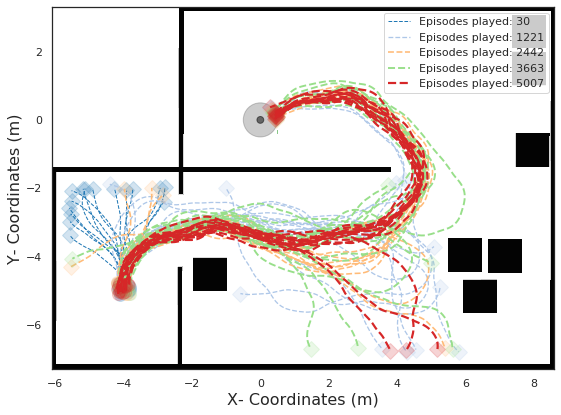

In [40]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_traj_forward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_train.png")

ax.imshow(img, extent=[-6.1, 8.6, -7.3, 3.3])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder)

### Backward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_traj_backward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (0., 0.)
env.target_pos = (-4., -5.)
env.start_orientation = (0., -1.5)
data = run_trajectories_tests(runs=15, checkpoints=[1, 40, 80, 120, 164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

Episode: 30, Success Rate:       0.00%
Episode: 1221, Success Rate:      66.67%
Episode: 2442, Success Rate:     100.00%
Episode: 3663, Success Rate:      93.33%
Episode: 5007, Success Rate:     100.00%


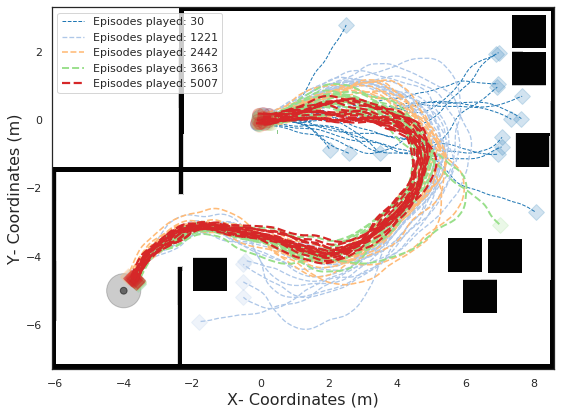

In [39]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_traj_backward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_train.png")

ax.imshow(img, extent=[-6.1, 8.6, -7.3, 3.3])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder)

## RL Train Runs

### Forward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_runs_forward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (-4., -5.)
env.target_pos = (0., 0.)
env.start_orientation = (1.5, 1.5)
data = run_trajectories_tests(runs=15, checkpoints=[164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

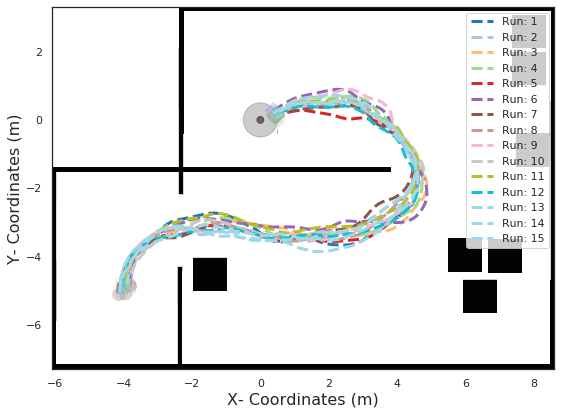

In [38]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_runs_forward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_train.png")

ax.imshow(img, extent=[-6.1, 8.6, -7.3, 3.3])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder,
                       typ='run')

### Backward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_runs_backward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (0., 0.)
env.target_pos = (-4., -5.)
env.start_orientation = (0., -1.5)
data = run_trajectories_tests(runs=15, checkpoints=[164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

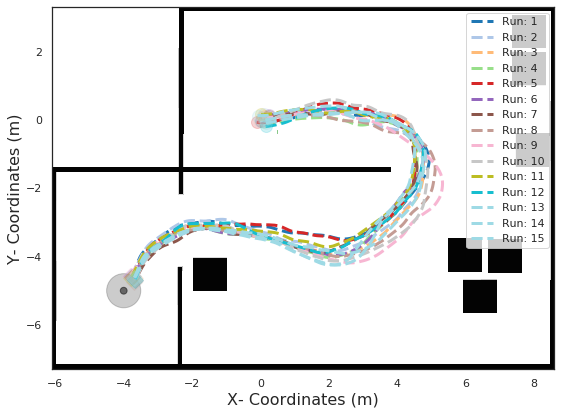

In [37]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/train_runs_backward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_train.png")

ax.imshow(img, extent=[-6.1, 8.6, -7.3, 3.3])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder,
                       typ='run')

## RL Val Trajectories

### Forward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_traj_forward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (-3.5,
                    -9.5)
env.target_pos = (-1., -6.5)
env.start_orientation = (0., -1.5)
data = run_trajectories_tests(runs=15, checkpoints=[1, 40, 80, 120, 164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

Episode: 30, Success Rate:       0.00%
Episode: 1221, Success Rate:      60.00%
Episode: 2442, Success Rate:      33.33%
Episode: 3663, Success Rate:      26.67%
Episode: 5007, Success Rate:      46.67%


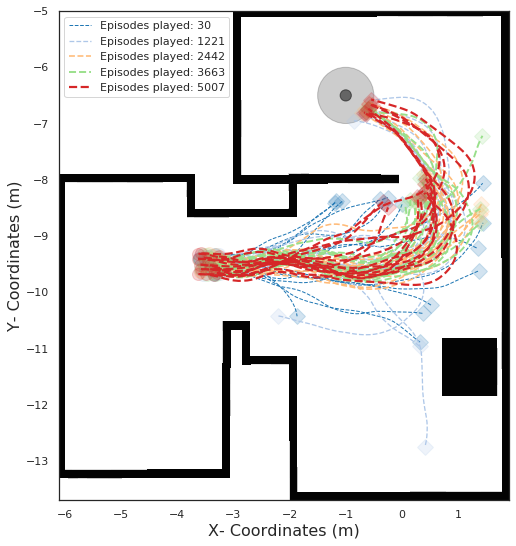

In [36]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_traj_forward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_val.png")

ax.imshow(img, extent=[-6.1, 1.9, -13.7, -5.0])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder)

### Backward

In [30]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_traj_backward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (-1.,
                    -6.5)
env.target_pos = (-3.5, -9.5)
env.start_orientation = (0., -1.5)
data = run_trajectories_tests(runs=15, checkpoints=[1, 40, 80, 120, 164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

(pid=409099) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=409099) Instructions for updating:
(pid=409099) non-resource variables are not supported in the long term
(pid=409099) [ERROR] [1614533828.533743, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=409099) [WARN] [1614533828.538378, 0.000000]: Start Init ControllersConnection
(pid=409099) [WARN] [1614533828.539397, 0.000000]: END Init ControllersConnection
2021-02-28 18:37:13,709	WARNING util.py:43 -- Install gputil for GPU system monitoring.
2021-02-28 18:37:13,823	INFO trainable.py:328 -- Restored on 192.168.178.60 from checkpoint: /home/dschori/ray_results/PPO_2021-02-17_15-27-03/PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/checkpoint_1/checkpoint-1
2021-02-28 18:37:13,824	INFO trainable.py:336 -- Curre

(pid=409099) None


KeyboardInterrupt: 

Episode: 30, Success Rate:       0.00%
Episode: 1221, Success Rate:      13.33%
Episode: 2442, Success Rate:      33.33%
Episode: 3663, Success Rate:      20.00%
Episode: 5007, Success Rate:      33.33%


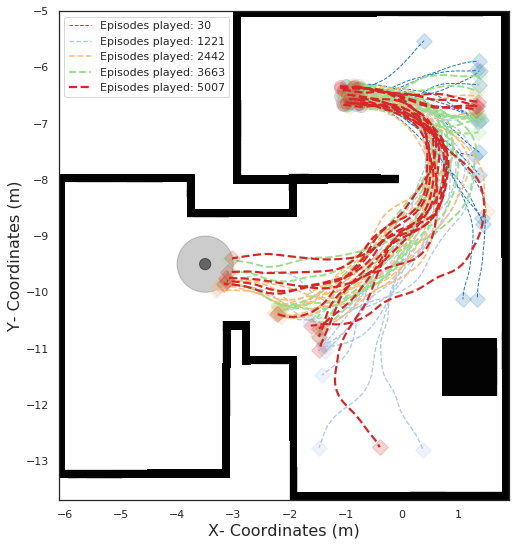

In [33]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_traj_backward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_val.png")

ax.imshow(img, extent=[-6.1, 1.9, -13.7, -5.0])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder)

## RL Val Runs

### Forward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_runs_forward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (-3.5, -9.5)
env.target_pos = (-1., -6.5)
env.start_orientation = (0., -1.5)
data = run_trajectories_tests(runs=15, checkpoints=[164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

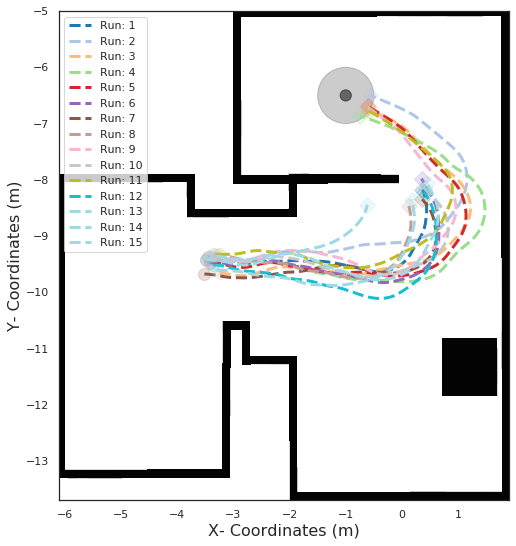

In [34]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_runs_forward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_val.png")

ax.imshow(img, extent=[-6.1, 1.9, -13.7, -5.0])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder,
                       typ='run')

### Backward

In [ ]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_runs_backward'
Path('{}/img_logs'.format(env.output_folder)).mkdir(parents=True, exist_ok=True)

env.starting_pos = (-1., -6.5)
env.target_pos = (-3.5, -9.5)
env.start_orientation = (0., -1.5)
data = run_trajectories_tests(runs=15, checkpoints=[164])

data['starting_pos'] = env.starting_pos
data['target_pos'] = env.target_pos

np.save('{}/data.npy'.format(env.output_folder), data)

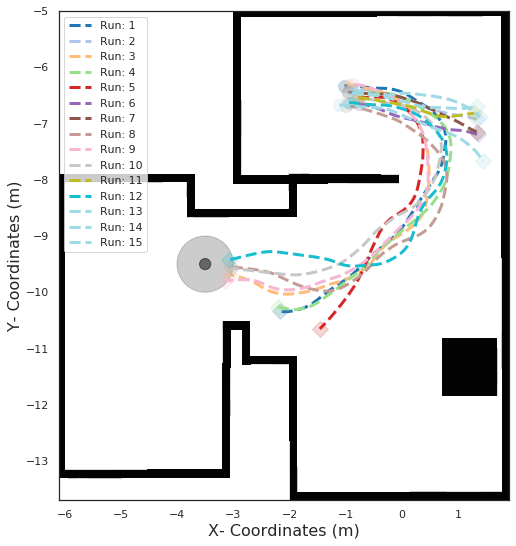

In [35]:
env.output_folder = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/val_runs_backward'
data = np.load('{}/data.npy'.format(env.output_folder), allow_pickle=True).item()

sns.set_theme(style="white")
_, ax = plt.subplots(1, 1, figsize=(9, 9))

img = plt.imread("../data/backgrounds/background_val.png")

ax.imshow(img, extent=[-6.1, 1.9, -13.7, -5.0])

visualize_trajectories(ax=ax,
                       data=data,
                       output_path=env.output_folder,
                       typ='run')

## RL Test Runs

In [73]:
def draw_environment(ax, direction, approach):
    ax.set_xlabel('X- Coordinates (m)', fontsize=16)
    ax.set_ylabel('Y- Coordinates (m)', fontsize=16)

    ax.set_xlim([-7., -0.5])
    ax.set_ylim([.5, -6.])

    obstacle = plt.Rectangle((-4.66, -3.32), width=100, height=0.32, alpha=0.8, color='black')
    ax.add_patch(obstacle)
    obstacle = plt.Rectangle((-2.64, -3.0), width=100, height=0.91, alpha=0.8, color='black')
    ax.add_patch(obstacle)
    obstacle = plt.Rectangle((-2.0, -1.0), width=1, height=100, alpha=0.8, color='black')
    ax.add_patch(obstacle)
    obstacle = plt.Rectangle((-6.4, -4.3), width=0.35, height=0.8, alpha=0.8, color='black')
    ax.add_patch(obstacle)
    obstacle = plt.Rectangle((-7, -6), width=0.6, height=100, alpha=0.8, color='black')
    ax.add_patch(obstacle)

    if direction == 'forward':
        ending_tolerance = plt.Circle((-4.2, -4.8), 0.1, alpha=0.5, color='black')
        ax.add_patch(ending_tolerance)
        ending_tolerance = plt.Circle((-4.2, -4.8), 0.5, alpha=0.2, color='black')
        ax.add_patch(ending_tolerance)
    elif direction == 'backward':
        starting_tolerance = plt.Circle((-1.35, -1.55), 0.1, alpha=0.5, color='black')
        ax.add_patch(starting_tolerance)
        starting_tolerance = plt.Circle((-1.35, -1.55), 0.5, alpha=0.2, color='black')
        ax.add_patch(starting_tolerance)

    return ax

def get_positions_from_bag():
    pass

def draw_trajectories(ax, direction, approach, rosbag_path):

    ax = draw_environment(ax=ax, direction=direction, approach=approach)

    def get_cmap(n, name='tab20'):
        '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
        RGB color; the keyword argument name must be a standard mpl colormap name.'''
        return plt.cm.get_cmap(name, n)


    cmap = get_cmap(150)
    legend_handles = []
    target_distribution = []

    if direction == 'forward':
        direction = 1
    elif direction == 'backward':
        direction = 2

    for i in range(15):
        folder = 'd{}_{}'.format(direction, i + 1)
        try:
            bag = rosbag.Bag('{}/{}/{}/data_0.bag'.format(rosbag_path, approach, folder))

            bag_transformer = BagTfTransformer('{}/{}/{}/data_0.bag'.format(rosbag_path, approach, folder))
        except rosbag.bag.ROSBagUnindexedException:
            continue

        x_s, y_s = [], []

        for topic, msg, t in bag.read_messages(topics=['/tf']):
            try:
                translation, quaternion = bag_transformer.lookupTransform('map', 'base_link', t)
                x_s.append(translation[0])
                y_s.append(translation[1])
            except:
                pass
        starting_point = (x_s[0], y_s[0])
        ending_point = (x_s[-1], y_s[-1])
        target_distribution.append(ending_point)
        ax.plot(*starting_point, marker='o', markersize=12, c=cmap(i * 10))
        ax.plot(*ending_point, marker='D', markersize=12, c=cmap(i * 10))
        line, = ax.plot(x_s, y_s, linestyle='dashed', linewidth=2, c=cmap(i * 10))
        line.set_label('Run {}'.format(i + 1))
        legend_handles.append(line)
        bag.close()

    starting_obj, = ax.plot((-100, -100), marker='o', markersize=12, c='black')
    starting_obj.set_label('Start')
    ending_obj, = ax.plot((-100, -100), marker='D', markersize=12, c='black')
    ending_obj.set_label('End')


    ax.legend()
    plt.gca().invert_yaxis()

### Forward

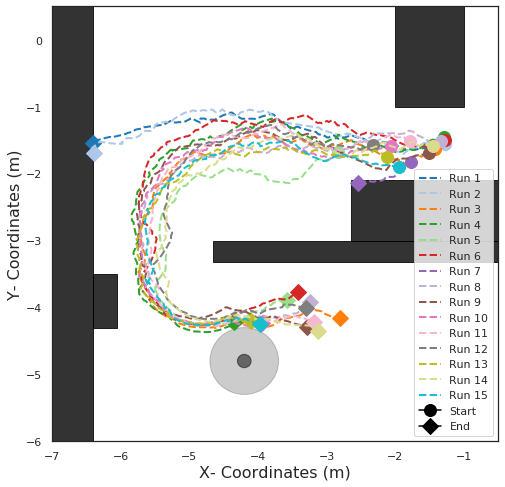

In [74]:
sns.set_theme(style="white")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax = draw_trajectories(ax=ax, approach='rl', direction='forward', rosbag_path='/home/dschori/rosbags_experiments')
output_path = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/test_runs_forward'
Path(output_path).mkdir(parents=True, exist_ok=True)
plt.savefig('{}/trajectories.png'.format(output_path), dpi=500)

### Backward

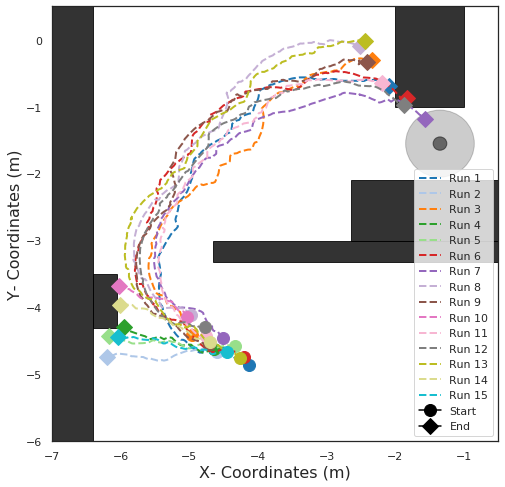

In [75]:
sns.set_theme(style="white")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax = draw_trajectories(ax=ax, approach='rl', direction='backward', rosbag_path='/home/dschori/rosbags_experiments')
output_path = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/test_runs_backward'
Path(output_path).mkdir(parents=True, exist_ok=True)
plt.savefig('{}/trajectories.png'.format(output_path), dpi=500)

## TEB Test Runs

### Forward

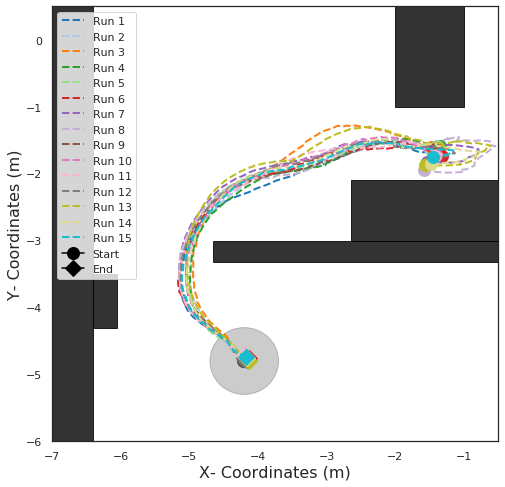

In [76]:
sns.set_theme(style="white")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax = draw_trajectories(ax=ax, approach='teb', direction='forward', rosbag_path='/home/dschori/rosbags_experiments')
output_path = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/teb_test_runs_forward'
Path(output_path).mkdir(parents=True, exist_ok=True)
plt.savefig('{}/trajectories.png'.format(output_path), dpi=500)

### Backward

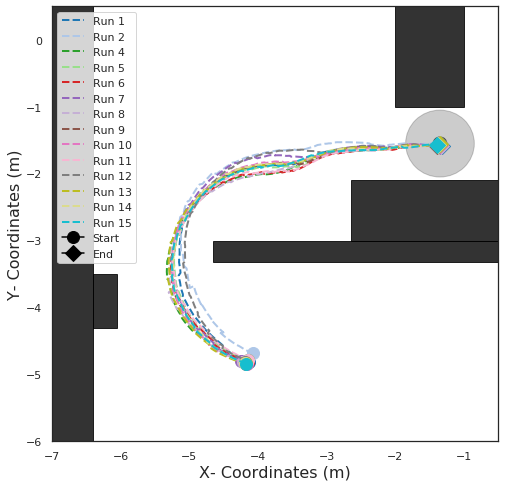

In [77]:
sns.set_theme(style="white")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax = draw_trajectories(ax=ax, approach='teb', direction='backward', rosbag_path='/home/dschori/rosbags_experiments')
output_path = '/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/data/teb_test_runs_backward'
Path(output_path).mkdir(parents=True, exist_ok=True)
plt.savefig('{}/trajectories.png'.format(output_path), dpi=500)

In [53]:
rosbag_path='/home/dschori/rosbags_experiments'

directions = [1, 2]
approaches = ['teb', 'rl']

end_positions = {
    1: (-4.2, -4.8),
    2: (-1.35, -1.55)
}
df_list = []
for direction in directions:
    for approach in approaches:
        for i in range(15):
            folder = 'd{}_{}'.format(direction, i + 1)
            try:
                bag = rosbag.Bag('{}/{}/{}/data_0.bag'.format(rosbag_path, approach, folder))

                bag_transformer = BagTfTransformer(
                    '{}/{}/{}/data_0.bag'.format(rosbag_path, approach, folder))
            except rosbag.bag.ROSBagUnindexedException:
                continue

            x_s, y_s = [], []

            for topic, msg, t in bag.read_messages(topics=['/tf']):
                try:
                    translation, quaternion = bag_transformer.lookupTransform('map', 'base_link', t)
                    x_s.append(translation[0])
                    y_s.append(translation[1])
                except:
                    pass
            starting_point = (x_s[0], y_s[0])
            ending_point = (x_s[-1], y_s[-1])
            str_dir = ''
            if direction == 1:
                str_dir = 'Forward'
            elif direction == 2:
                str_dir = 'Backward'
            df_list.append(
                {
                    'Approach': approach,
                    'Direction': str_dir,
                    'Target Position': end_positions[direction],
                    'Actual Position': ending_point,
                    'Distance to Target': math.dist(ending_point, end_positions[direction])
                }
            )
            bag.close()

data = pd.DataFrame(df_list)

/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py:63: UserWarning: translation should be of type Vector3
  self._buffer.set_transform(transform, authority)
/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py:63: UserWarning: rotation should be of type Quaternion
  self._buffer.set_transform(transform, authority)
/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/scripts/tf_bag.py:99: UserWarning: translation should be of type Vector3
  self.transformer._buffer.set_transform_static(st_tfm, "default_authority")
/home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-scouting/scouting_train/scripts/tf_bag.py:99: UserWarning: rotation should be of type Quaternion
  self.transformer._buffer.set_transform_static(st_tfm, "default_authority")


In [2]:
data.to_pickle('../data/data_frame_test_runs.pkl')

NameError: name 'data' is not defined

In [67]:
data = pd.read_pickle('../data/data_frame_test_runs.pkl')

In [68]:
new_data = []

folders = [
    'train_runs_backward',
    'train_runs_forward',
    'val_runs_backward',
    'val_runs_forward',
]

data_path = '../data'

for folder in folders:
    tmp_data = np.load('{}/{}/data.npy'.format(data_path, folder),allow_pickle=True).item()
    direction = folder.split('_')[-1].title()
    approach = 'rl_{}_sim'.format(folder.split('_')[0])
    for run_key, run_positions in tmp_data['trajectories']['checkpoint_traj_164'].items():
        new_data.append(
            {
                'Approach': approach,
                'Direction': direction,
                'Target Position': tmp_data['target_pos'],
                'Actual Position': run_positions[-1],
                'Distance to Target': math.dist(run_positions[-1], tmp_data['target_pos'])
            }
        )

new_data = pd.DataFrame(new_data)
data = data.append(new_data)

In [69]:
data.to_pickle('../data/data_frame_runs.pkl')

In [78]:
data = pd.read_pickle('../data/data_frame_runs.pkl')
log_data = [np.log10(d) for d in data['Distance to Target']]
data['Distance to Target'] = log_data

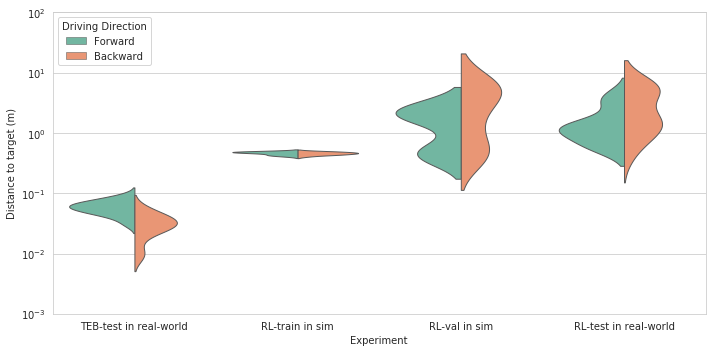

In [79]:
from matplotlib import ticker as mticker
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.violinplot(data=data, x="Approach", y="Distance to Target", hue='Direction',
               split=True, inner=None, linewidth=1,
               palette='Set2', legend_out=False, ax=ax,
                    order=[ "teb", "rl_train_sim", "rl_val_sim", "rl"])
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x:.1f}$"))
ax.yaxis.set_ticks([np.log10(x) for p in range(-5,2) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
ax.set(ylim=(-3, 2))
ax.set(xlabel='Experiment', ylabel='Distance to target (m)')
ax.set_xticklabels(['TEB-test in real-world', 'RL-train in sim', 'RL-val in sim', 'RL-test in real-world'])
ax.legend(loc='upper left')
plt.legend(title='Driving Direction', loc='upper left', labels=['Forward', 'Backward'])
plt.tight_layout()
plt.savefig('../data/violin_distribution.png', dpi=600)
plt.show()

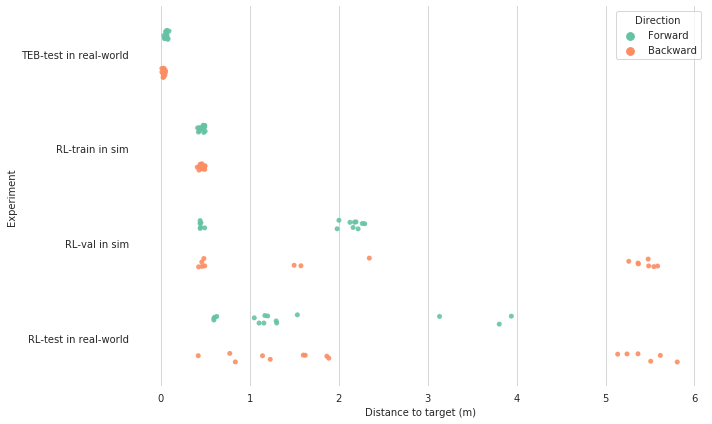

In [77]:
data = pd.read_pickle('../data/data_frame_runs.pkl')
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
ax = sns.stripplot(x="Distance to Target", y="Approach", hue="Direction",
              data=data, palette='Set2', dodge=True, alpha=.9, zorder=1, ax=ax,
                    order=[ "teb", "rl_train_sim", "rl_val_sim", "rl"])
ax.set(xlabel='Distance to target (m)', ylabel='Experiment')
ax.set_yticklabels(['TEB-test in real-world', 'RL-train in sim', 'RL-val in sim', 'RL-test in real-world'])
plt.tight_layout()
plt.savefig('../data/point_distribution.png', dpi=600)

## Network learnings

In [7]:
checkpoint_nr = 164
checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                  'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
agent = load(checkpoint_path=checkpoint_path, config=config)
policy = agent.get_policy()
model = policy.model.base_model
model.summary()

2021-03-08 12:08:35,068	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-03-08 12:08:35,070	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=39587) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=39587) Instructions for updating:
(pid=39587) non-resource variables are not supported in the long term
(pid=39587) /home/dschori/MasterThesis/ackerbot_sim_ws/src/rl-navigation/navigation_gym/src/navigation_gym/tasks/navigation_discrete_task.py:25: UserWarning: 'rl-navigation_39587_1615201718164' is not a legal ROS base name. This may cause problems with other ROS tools.
(pid=39587)   rospy.init_node('rl-navigation', anonymous=True, log_level=rospy.INF

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv_value_1 (Conv2D)           (None, 21, 21, 16)   4112        observations[0][0]               
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 21, 21, 16)   4112        observations[0][0]               
__________________________________________________________________________________________________
conv_value_2 (Conv2D)           (None, 11, 11, 32)   8224        conv_value_1[0][0]               
______________________________________________________________________________________________

In [8]:
weights = policy.get_weights()
print(weights.keys())

odict_keys(['default_policy/conv_value_1/kernel', 'default_policy/conv_value_1/bias', 'default_policy/conv1/kernel', 'default_policy/conv1/bias', 'default_policy/conv_value_2/kernel', 'default_policy/conv_value_2/bias', 'default_policy/conv2/kernel', 'default_policy/conv2/bias', 'default_policy/conv_value_3/kernel', 'default_policy/conv_value_3/bias', 'default_policy/conv3/kernel', 'default_policy/conv3/bias', 'default_policy/conv_value_out/kernel', 'default_policy/conv_value_out/bias', 'default_policy/conv_out/kernel', 'default_policy/conv_out/bias'])


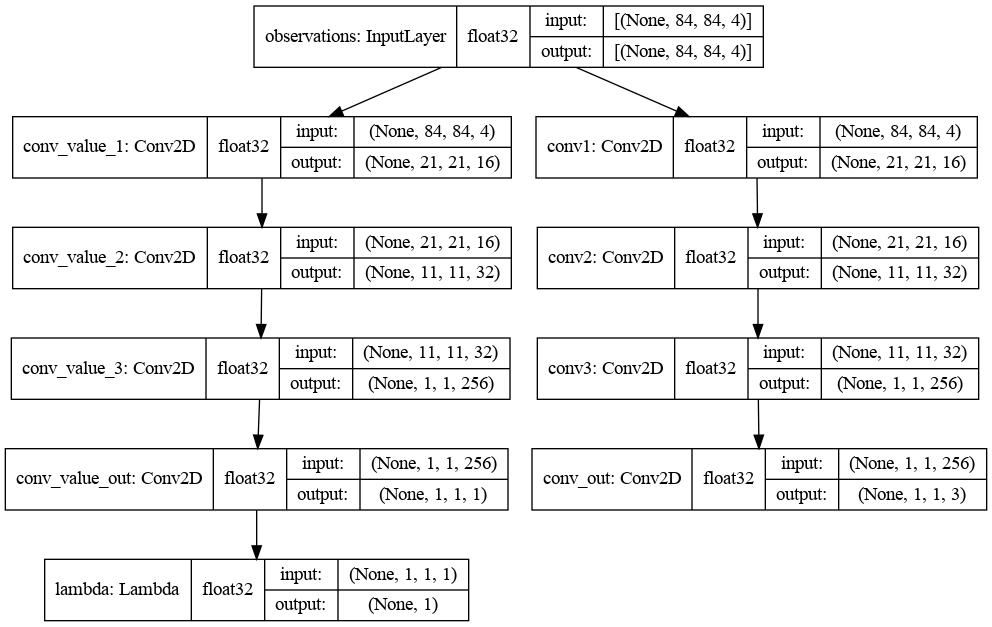

In [10]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_dtype=True)

In [11]:
inputs = tf.keras.Input(shape=(84, 84, 4,))
x = tf.keras.layers.Conv2D(16, (8, 8), strides=(4, 4), padding='same', name='conv1')(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', name='conv2')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(256, (11, 11), strides=(1, 1), padding='valid', name='conv3')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(3, (1, 1), strides=(1, 1), padding='valid', name='conv_out')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(loss='mse')
model.summary()

model.layers[1].set_weights([weights['default_policy/conv1/kernel'], weights['default_policy/conv1/bias']])
model.layers[3].set_weights([weights['default_policy/conv2/kernel'], weights['default_policy/conv2/bias']])
model.layers[5].set_weights([weights['default_policy/conv3/kernel'], weights['default_policy/conv3/bias']])
model.layers[7].set_weights([weights['default_policy/conv_out/kernel'], weights['default_policy/conv_out/bias']])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 21, 21, 16)        4112      
_________________________________________________________________
re_lu (ReLU)                 (None, 21, 21, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        8224      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 11, 11, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 256)         991488    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 1, 1, 256)         0     

In [12]:
preprocessed = agent.workers.local_worker().preprocessors["default_policy"].transform(obs)
filtered_obs = agent.workers.local_worker().filters["default_policy"](preprocessed, update=False)

conv_1 = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[2].output)
conv_2 = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
conv_3 = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[6].output)
pred_1 = conv_1.predict(filtered_obs.reshape(1, 84, 84, 4))
pred_2 = conv_2.predict(filtered_obs.reshape(1, 84, 84, 4))
pred_3 = conv_3.predict(filtered_obs.reshape(1, 84, 84, 4))

/home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


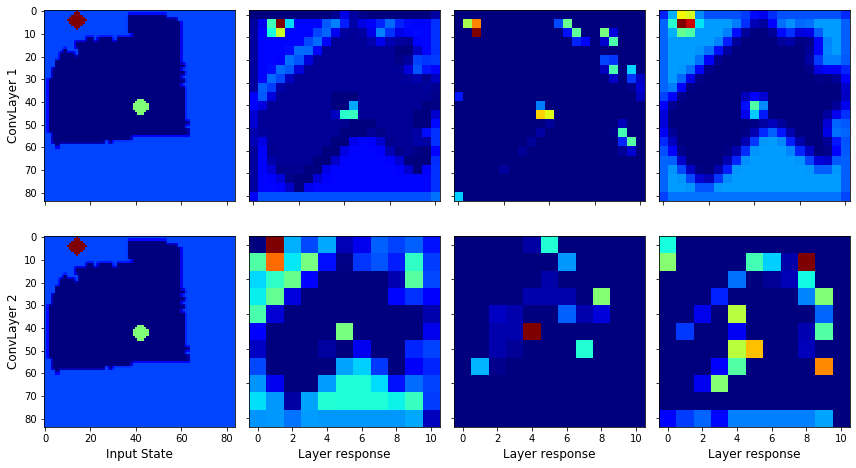

In [13]:
import numpy as np
obs = np.load('../data/obs_learning.npy')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 7))

cols = ['{}'.format(col) for col in ['Input State', 'Layer response', 'Layer response', 'Layer response']]
rows = ['ConvLayer {}'.format(row) for row in range(1, 4)]

for i in range(2):
    axes[i, 0].imshow(obs[:, :, 0], vmin=0., vmax=1., cmap='jet')

for i, kernel in enumerate([6, 10, 15]):
    axes[0, 1+i].imshow(pred_1[0, :, :, kernel], cmap='jet')

for i, kernel in enumerate([1, 6, 12]):
    axes[1, 1+i].imshow(pred_2[0, :, :, kernel], cmap='jet')

for ax in axes.flat:
    ax.label_outer()

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.setp(axes[-1, 1:], xlabel='Layer response')

for i, col in enumerate(cols):
    axes[-1, i].set_xlabel(col, size=12)

plt.tight_layout()
plt.savefig('layer_respones.png', dpi=300)